# Demo 1: Flow

Flow is a fundamental driver of processes in the surface and subsurface. In this set of demonstrations we will introduce

  * Richards Model for variably saturated subsurface flow
  * Diffusion Wave model for overland flow (surface flow)
  * A fully coupled (integrated hydrology) model

For each model we will provide the mathematical equations, highlight information about the discretization and provide tips on setting boundary conditions, initial conditions, source terms and key parameters.

## Subsurface Flow (Richards Equation)

Richards (1931) model for variably saturated flow:

$\newcommand{porosity}{\phi}$
$\newcommand{dens}{n_l}$
$\newcommand{sat}{s}$
$\newcommand{flux}{\mathbf{q}}$
$\newcommand{krel}{k_r}$
$\newcommand{kabs}{\kappa}$
$\newcommand{viscosity}{\mu}$

$$
\begin{align}
  \frac{\partial}{\partial t} (\porosity \dens \sat) &+ \nabla \cdot \flux = 0 \\
  \flux &= - \dens \frac{\krel \kabs}{\viscosity} (\nabla p + \rho \mathbf{g})
\end{align}
$$

Water retention models?



### Model Setup: Infiltration into a soil column (1D) 
These tests demonstrate solution of Richards equation on a single column. A single column of cells, oriented vertically, are initialized as the hydrostatic solution with the water table at 7m. Infilitration is turned on, and water fills the domain.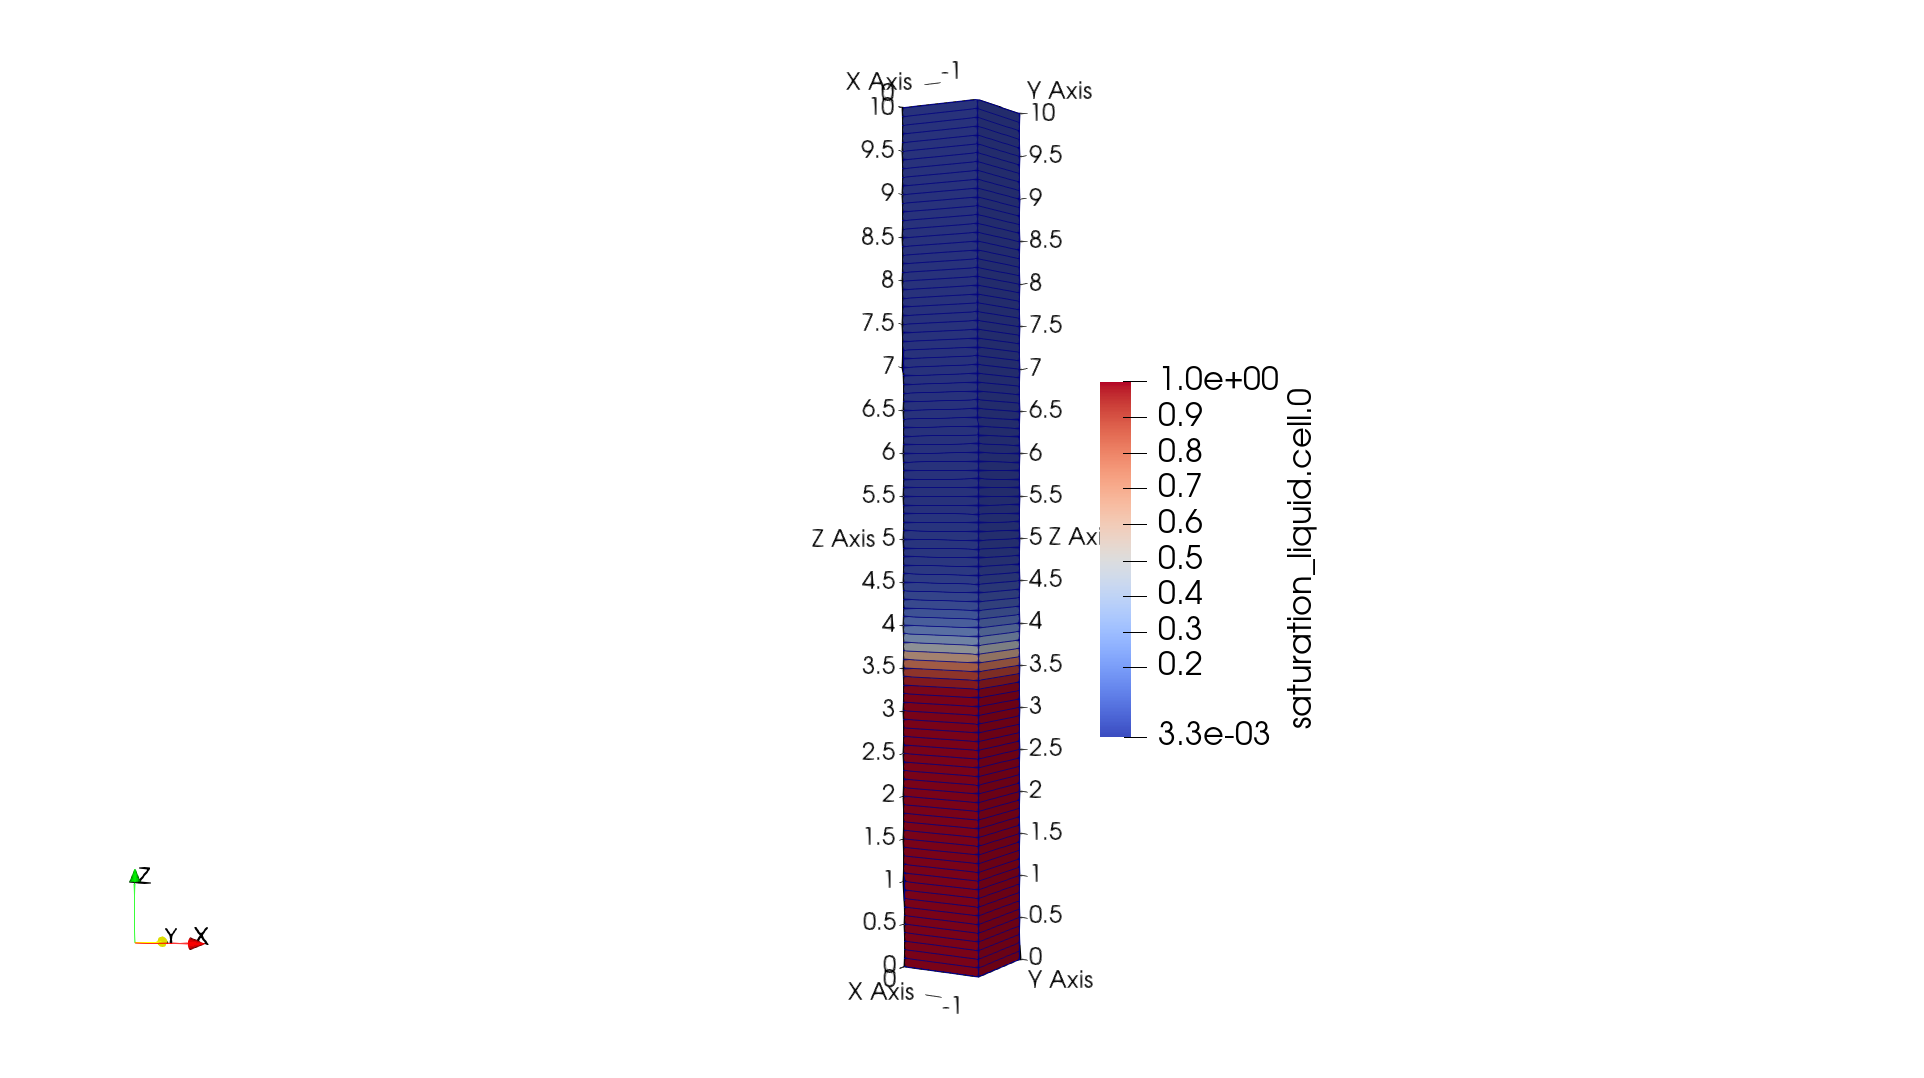

### Simulation Results 
After running the simulation we can plot the results using some of the python utilities provided by ATS. In this case we will plot the saturation as a function of depth, at several times.

In [1]:
%matplotlib inline

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import plot_column_data
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def plot(dirname, title):
    """A generic plotting function that plots saturation as a function of depth."""
    fig = plt.figure()

    vis = ats_xdmf.VisFile(dirname, time_unit='d')
    vis.loadMesh(columnar=True)
    
    # plot the solution
    ax = fig.subplots(1,1)
    plot_column_data.plot_subsurface(vis, ['saturation_liquid',], ax, None, cmap='jet')
    ax.set_title(title)
    ax.set_xlabel('saturation [-]')
    ax.set_ylabel('z [m]')

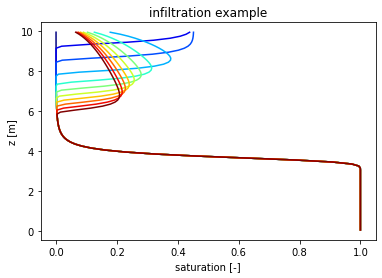

In [4]:
plot("./richards/run/", "infiltration example")

Text(0, 0.5, '$mol\\cdot m^{-2}\\cdot s^{-1}$')

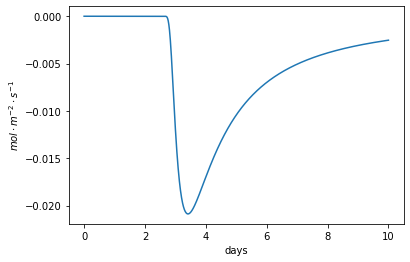

In [5]:
import numpy as np
from matplotlib import pyplot as plt

flux_data = np.loadtxt("./richards/run/observation_flux.dat",skiprows=11)
flux_data = np.transpose(flux_data)
fig = plt.figure()
ax = fig.subplots(1,1)
plt.plot(flux_data[0]/86400, flux_data[1])
ax.set_xlabel("days")
ax.set_ylabel(r"$mol\cdot m^{-2}\cdot s^{-1}$")


## Overland Flow (Diffusion Wave Equation)

Diffusion wave model for overland flow

$\newcommand{pondeddepth}{\delta_w}$
$\newcommand{watersource}{q_w}$
$\newcommand{flux}{{\bf U_w}}$
$\newcommand{manning}{n_{man}}$


$$
\begin{align}
  \frac{\partial \pondeddepth}{\partial t}  &+ \nabla \cdot \pondeddepth \flux = \watersource \\
  \flux &= -\displaystyle\frac{\pondeddepth^{2/3}}{\manning\left(||\nabla Z_s|| + \varepsilon\right)^{1/2}}
  \nabla\left(\nabla Z_s + \pondeddepth\right)
\end{align}
$$


$\pondeddepth$ - ponded depth
$\watersource$ - water source
$Z_s$ - surface elevation
$\manning$ - Manning’s coefficient


### Model Setup: Rainfall on a Hillslope 

The test demonstrate rainfall event over hillslope domain with different boundary conditions. 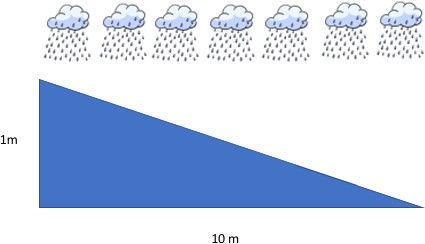

### Boundary conditions:

A complete description of supported boundary conditions is provided in the documentation of the input specification online, e.g., for flow BCs see [ATS input specification v1.2 - flow-specific-boundary-conditions](https://github.com/amanzi/ats/blob/master/docs/documentation/source/input_spec/ATSNativeSpec_1_2.rst#flow-specific-boundary-conditions).  Here we focus on four important boundary conditions for surface flow.

**No-Flow**: 

The default boundary condition is no-flow, and is set with an empty list,

```xml
<ParameterList name="boundary conditions" type="ParameterList">
</ParameterList>
```

**Critical Depth**: 

This is an _outlet_ boundary condition which looks to set an outward flux to take away runoff. This condition is given by the following condition on outward flux 

$$q = \sqrt{g\hat z} n_{w} h^{3/2}$$

It is described in the input spec as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="critical depth" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
    </ParameterList>
  </ParameterList>
</ParameterList>
```


**Zero Head Gradient:**

This is an _outlet_ boundary condition which looks to enforce the condition that

$$ \nabla h \cdot n = 0 $$

but should only be used on boundaries where

$$ \nabla Z \cdot n  < 0 $$

This is expressed in the input file as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="zero gradient" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
    </ParameterList>
  </ParameterList>
</ParameterList>
```    

**Max Head or Surface Seepage:**

This allows water to flow out once the ponded depth exceeds the specified head, but does not allow flow back into the domain:

if ${\bf U}_w\cdot n < 0$ then we set ${\bf U}_w\cdot n = 0$

if $ h > h_{max}$ then we set $h = h_{max}$

And is written in the input file as

```xml
<ParameterList name="boundary conditions" type="ParameterList">
  <ParameterList name="seepage face head" type="ParameterList">
    <ParameterList name="outlet" type="ParameterList">
      <Parameter name="regions" type="Array(string)" value="{right side}" />
      <ParameterList name="boundary head" type="ParameterList">
        <ParameterList name="function-constant" type="ParameterList">
          <Parameter name="value" type="double" value="0.025" />
        </ParameterList>
      </ParameterList>
    </ParameterList>
  </ParameterList>
</ParameterList>
```

### Simulation Results

In [67]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import colors
import numpy as np
from matplotlib import pyplot as plt
import pandas

In [68]:
def plot_surface(directory):
    """A generic plotting script plotting ponded depth and discharge/runoff"""
    vis = ats_xdmf.VisFile(directory, domain='surface', time_unit='s')
    vis.loadMesh(order=['x','y'])

    cm = colors.cm_mapper(vis.times[0], vis.times[-1], cmap='jet')
    x = vis.centroids[:,0]

    fig, ax = plt.subplots(1,2, figsize=(14,3))

    # This simply gets a colorbar axis
    C = [[0,0],[0,0]]
    C3 = ax[0].contourf(C, vis.times, cmap='jet')
    ax[0].cla()  

    pd = vis.getArray('surface-ponded_depth')
    elev = vis.get('surface-elevation', '0')

    #ax[0].plot(x, elev, 'k')
    for i,time in enumerate(vis.times):
        #ax[0].plot(x, elev + pd[i,:], color=cm(i))
        #print(cm(i))
        ax[0].plot(x, pd[i,:], color=cm(time))

    ax[0].set_xlabel('x-coordinate [m]')
    ax[0].set_ylabel('ponded depth [m]')
    
    hydro = np.loadtxt(os.path.join(directory, 'surface_outlet_flux.dat'), skiprows=11)
    hydro = np.transpose(hydro)
    ax[1].plot(hydro[0][:]/60.0, hydro[1][:], 'b')
    ax[1].set_xlabel('time [min]')
    ax[1].set_ylabel('discharge flow rate [mol/s]')
    
    cbar = plt.colorbar(C3, ax=ax[0])
    cbar.ax.set_ylabel("time [s]")
    
    plt.tight_layout()
    plt.show()

<function cm_mapper.<locals>.mapper at 0x11e5f4cb0>


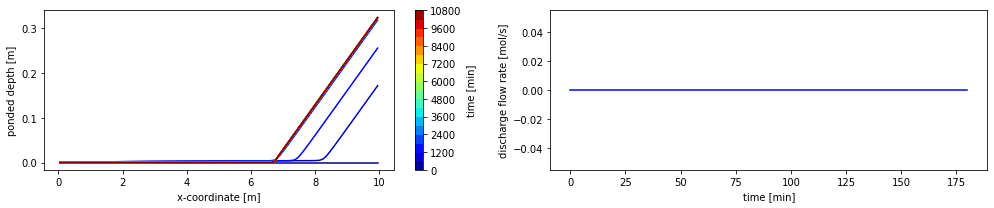

In [69]:
plot_surface("overland_flow/run_no_flow")

<function cm_mapper.<locals>.mapper at 0x11eabbe60>


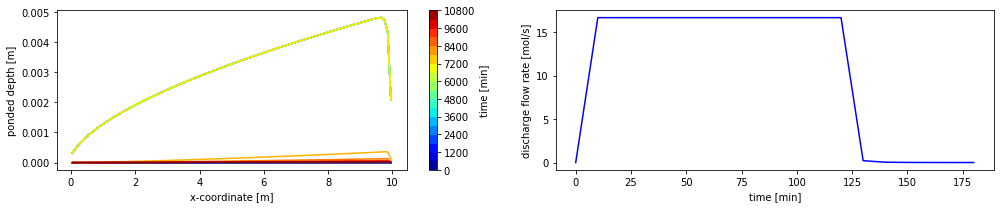

In [70]:
plot_surface("overland_flow/run_critical_depth")

<function cm_mapper.<locals>.mapper at 0x11efd4200>


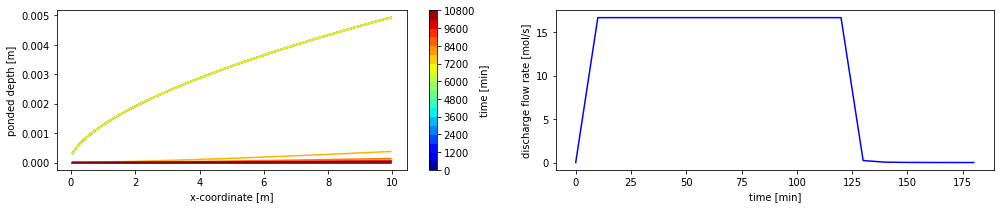

In [71]:
plot_surface("overland_flow/run_zero_gradient")

<function cm_mapper.<locals>.mapper at 0x11f45a710>


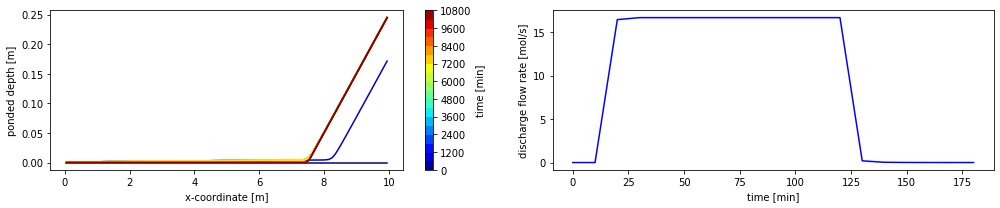

In [72]:
plot_surface("overland_flow/run_max_head")

## Integrated Hydrology

# 3D domain

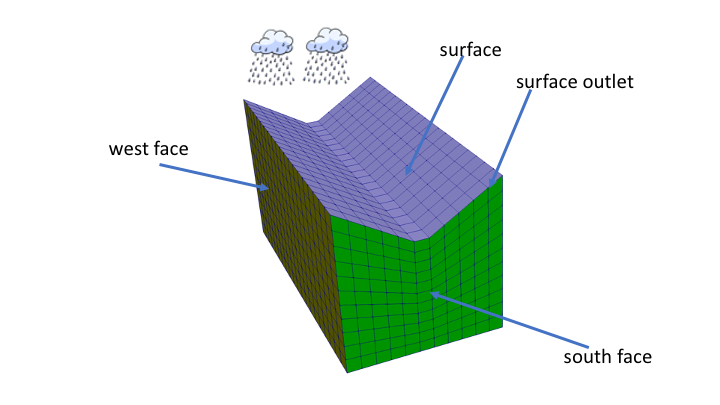
Parameters of 3D simulation:

-- simulation start: 0 day

-- simulation end:  0.8 day

-- initial condition: hydrostatic pressure with water table at 6.0m

-- boundary condition (subsurface): no-flow boundary condition

-- boundary condition (surface) : zero-gradient conditions at surface outlet



In [114]:
def plot_transect(directory):
    vis = ats_xdmf.VisFile(directory, domain='surface', filename='ih_surface_data.h5', mesh_filename='ih_surface_mesh.h5', time_unit='s')
    vis.loadMesh(order=['x','y'])
    y = vis.centroids[:,1]
    pd = vis.getArray('surface-ponded_depth')
    cm = colors.cm_mapper(vis.times[0], vis.times[-1], cmap='jet')
        
    fig, ax = plt.subplots(1,2, figsize=(14,3))
    
    # This simply gets a colorbar axis
    C = [[0,0],[0,0]]
    C3 = ax[0].contourf(C, vis.times, cmap='jet')
    ax[0].cla()
    
    for i,time in enumerate(vis.times):
        #ax[0].plot(x, elev + pd[i,:], color=cm(i))
        #print(cm(i))
        ax[0].plot(y[100:119], pd[i,100:119], color=cm(time))

    ax[0].set_xlabel('y-coordinate [m]')
    ax[0].set_ylabel('ponded depth [m]')
    
    cbar = plt.colorbar(C3, ax=ax[0])
    cbar.ax.set_ylabel("time [s]")
    
    #ax[0].plot(y[120:139], pd[10,120:139], 'b-')
    #ax[0].plot(y[100:119], pd[10,100:119], 'r-')
    #ax[0].plot(y[80:99], pd[10,80:99], 'g-')
    
    out_flux = np.loadtxt(os.path.join(directory,'surface_outlet_flux.dat'), skiprows=11)
    out_flux = np.transpose(out_flux)
    ax[1].plot(out_flux[0][:]/3600.0, out_flux[1][:], 'b')
    ax[1].set_xlabel('time [h]')
    ax[1].set_ylabel('discharge flow rate [mol/s]')


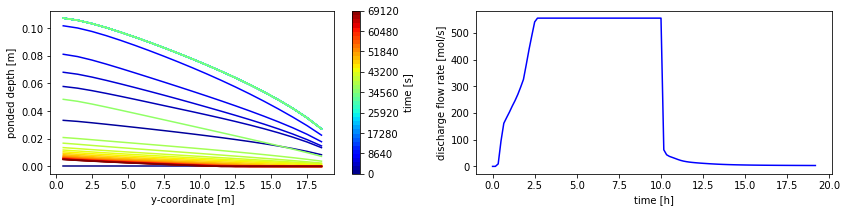

In [115]:
plot_transect('integrated_hydro/run_3D_results')